In [63]:
import librosa
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import re
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
# import zscore
from scipy.stats import zscore

In [ ]:
#initialize the matrix with names of the audio files in the directory
folder = 'audios/micro_medlydb/validate'

#create a numpy matrix to store the names of the audio files
audio_files = np.array([f for f in os.listdir(folder) if f.endswith('.wav')])

df = pd.DataFrame(audio_files, columns=['filename'])

#load and compute the features for the test set
test_folder = 'audios/micro_medlydb/test'
#create a numpy matrix to store the names of the audio files
audio_files = np.array([f for f in os.listdir(test_folder) if f.endswith('.wav')])

df_test = pd.DataFrame(audio_files, columns=['filename'])

df_test


,filename
0,Medley-solos-DB_test-7_45687e10-11f7-5ae0-f2ef...
1,Medley-solos-DB_test-6_958fc95b-7a96-5c85-f5f5...
2,Medley-solos-DB_test-3_3b4a89d5-c6e4-59b9-fc5a...
3,Medley-solos-DB_test-7_24a7fd1b-1d85-5ebc-f76d...
4,Medley-solos-DB_test-4_f7af6fc5-4b4f-5b83-f7c1...
5,Medley-solos-DB_test-6_417eedc8-b71a-55ca-f7df...
6,Medley-solos-DB_test-7_995fe142-f590-570e-faca...
7,Medley-solos-DB_test-3_3f8f1614-6891-567b-ff45...
8,Medley-solos-DB_test-4_ffa4df14-5fec-5eae-f37a...
9,Medley-solos-DB_test-7_6d3d5de1-a36a-59ba-f061...


In [65]:

def label_extraction(folder, df):
    #parse the label out of the file name
    pattern = re.compile(r'DB_validation-(\d+)_|DB_test-(\d+)_')  # strictly matches the number after DB_validation- or DB_test-

    for filename in os.listdir(folder):
        match = pattern.search(filename)
        if match:
            number = int(match.group(1) or match.group(2))  # extract the correct number
            df.loc[df['filename'] == filename, 'label'] = number

    df['label'] = df['label'].astype('Int64')  # Pandas nullable integer type
    return df

df = label_extraction(folder, df)



df_test = label_extraction(test_folder, df_test)

df_test

,filename,label
0,Medley-solos-DB_test-7_45687e10-11f7-5ae0-f2ef...,7
1,Medley-solos-DB_test-6_958fc95b-7a96-5c85-f5f5...,6
2,Medley-solos-DB_test-3_3b4a89d5-c6e4-59b9-fc5a...,3
3,Medley-solos-DB_test-7_24a7fd1b-1d85-5ebc-f76d...,7
4,Medley-solos-DB_test-4_f7af6fc5-4b4f-5b83-f7c1...,4
5,Medley-solos-DB_test-6_417eedc8-b71a-55ca-f7df...,6
6,Medley-solos-DB_test-7_995fe142-f590-570e-faca...,7
7,Medley-solos-DB_test-3_3f8f1614-6891-567b-ff45...,3
8,Medley-solos-DB_test-4_ffa4df14-5fec-5eae-f37a...,4
9,Medley-solos-DB_test-7_6d3d5de1-a36a-59ba-f061...,7


In [66]:
def z_score_normalization(x):
    return (x - np.mean(x)) / np.std(x)

In [71]:

def feature_extraction(folder, df):

    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if not file.endswith('.wav'):
            continue
        # Read file
        audio_data, sr = librosa.load(file_path)

        # DC offset
        audio_data = audio_data - np.mean(audio_data)
        # Normalize
        audio_data = audio_data / np.max(np.abs(audio_data))

        '''
        NOTE:
        Revist STFT variables later
        '''

        # Spectral centroid
        centroid = librosa.feature.spectral_centroid(y=audio_data, sr=sr)[0]
        centroid = z_score_normalization(centroid)
        centroid_mean = np.mean(centroid)
        #store in dataframe
        df.loc[df['filename'] == file, 'centroid_mean'] = centroid_mean

        # Spectral spread
        spread = librosa.feature.spectral_bandwidth(y=audio_data, sr=sr)[0]
        spread = z_score_normalization(spread)
        spread_mean = np.mean(spread)
        df.loc[df['filename'] == file, 'spread_mean'] = spread_mean

        # Spectral rolloff
        rolloff = librosa.feature.spectral_rolloff(y=audio_data, sr=sr)[0]
        rolloff = z_score_normalization(rolloff)
        rolloff_mean = np.mean(rolloff)
        df.loc[df['filename'] == file, 'rolloff_mean'] = rolloff_mean

        # Spectral flatness
        flatness = librosa.feature.spectral_flatness(y=audio_data)[0]
        flatness = z_score_normalization(flatness)
        flatness_mean = np.mean(flatness)
        df.loc[df['filename'] == file, 'flatness_mean'] = flatness_mean

        # Zero-crossing rate
        zcr = librosa.feature.zero_crossing_rate(y=audio_data)[0]
        zcr = z_score_normalization(zcr)
        zcr_mean = np.mean(zcr)
        df.loc[df['filename'] == file, 'zcr_mean'] = zcr_mean

        # Spectral flux
        spectrogram = np.abs(librosa.stft(audio_data))
        L2_norms = np.linalg.norm(spectrogram, axis=0)
        spectrogram = spectrogram / L2_norms
        flux = np.sum(np.diff(spectrogram, axis=1) ** 2, axis=0)
        flux = z_score_normalization(flux)
        flux_mean = np.mean(flux)
        df.loc[df['filename'] == file, 'flux_mean'] = flux_mean

        # MFCC
        mfcc = librosa.feature.mfcc(y=audio_data, sr=sr, n_mfcc=10)
        mfcc = (mfcc - np.mean(mfcc, axis=1, keepdims=True)) / np.std(mfcc, axis=1, keepdims=True)
        mfcc_means = np.mean(mfcc, axis=1)
        for i, mfcc_mean in enumerate(mfcc_means):
            df.loc[df['filename'] == file, f'mfcc_{i+1}_mean'] = mfcc_mean
        
    return df
    
df = feature_extraction(folder, df)

df_test = feature_extraction(test_folder, df_test)
df_test

,filename,label,centroid_mean,spread_mean,rolloff_mean,flatness_mean,zcr_mean,flux_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean
0,Medley-solos-DB_test-7_45687e10-11f7-5ae0-f2ef...,7,8.262125e-17,-1.445872e-16,2.616340e-16,1.201334e-08,2.203233e-16,-3.725290e-08,-2.291775e-07,-2.217847e-07,2.957130e-08,8.132107e-08,-5.914259e-08,1.404637e-07,-2.476596e-07,-2.957130e-08,-5.914259e-08,-1.626421e-07
1,Medley-solos-DB_test-6_958fc95b-7a96-5c85-f5f5...,6,0.000000e+00,8.468678e-16,0.000000e+00,0.000000e+00,-1.101617e-16,-7.450581e-09,-1.774278e-07,-2.957130e-08,-3.104986e-07,5.914259e-08,0.000000e+00,-5.174977e-08,8.871389e-08,-2.587488e-08,-5.914259e-08,4.435694e-08
2,Medley-solos-DB_test-3_3b4a89d5-c6e4-59b9-fc5a...,3,-2.754042e-16,-3.304850e-16,0.000000e+00,0.000000e+00,2.754042e-17,7.450581e-08,2.957130e-08,-1.774278e-07,-2.957130e-08,1.108924e-08,2.957130e-08,-4.435694e-08,7.392824e-09,2.957130e-08,-2.957130e-08,8.871389e-08
3,Medley-solos-DB_test-7_24a7fd1b-1d85-5ebc-f76d...,7,-1.652425e-16,9.501444e-16,3.029446e-16,-1.478565e-08,5.508083e-17,7.450581e-09,2.365704e-07,-4.435694e-08,-1.663386e-08,-1.182852e-07,2.957130e-08,1.478565e-08,5.174977e-08,-1.108924e-08,-1.034995e-07,2.957130e-08
4,Medley-solos-DB_test-4_f7af6fc5-4b4f-5b83-f7c1...,4,-1.467388e-16,-3.580254e-16,-2.754042e-17,3.696412e-08,-2.358148e-16,2.607703e-08,8.686568e-08,3.548556e-07,8.871389e-08,0.000000e+00,1.478565e-08,5.914259e-08,2.957130e-08,4.435694e-08,5.914259e-08,0.000000e+00
5,Medley-solos-DB_test-6_417eedc8-b71a-55ca-f7df...,6,1.308170e-16,-3.924509e-16,-2.573308e-16,0.000000e+00,2.065531e-16,1.490116e-07,2.957130e-08,5.174977e-08,-8.871389e-08,8.871389e-08,-5.914259e-08,-3.881233e-08,-8.132107e-08,-1.071960e-07,1.108924e-07,-5.821849e-08
6,Medley-solos-DB_test-7_995fe142-f590-570e-faca...,7,-2.203233e-16,9.363741e-16,1.927829e-16,7.392824e-09,2.203233e-16,-6.705523e-08,-2.957130e-08,3.474627e-07,3.104986e-07,-6.607337e-08,-2.957130e-08,-2.957130e-08,1.182852e-07,4.435694e-08,1.478565e-07,-8.132107e-08
7,Medley-solos-DB_test-3_3f8f1614-6891-567b-ff45...,3,-5.508083e-16,-3.855658e-16,1.377021e-16,1.478565e-08,-9.639146e-17,0.000000e+00,0.000000e+00,2.365704e-07,-1.774278e-07,-8.871389e-08,-5.914259e-08,0.000000e+00,1.478565e-07,1.256780e-07,-2.217847e-08,1.034995e-07
8,Medley-solos-DB_test-4_ffa4df14-5fec-5eae-f37a...,4,-3.855658e-16,1.101617e-15,-1.927829e-16,7.392824e-09,-1.101617e-16,2.235174e-08,-8.871389e-08,-6.801398e-07,2.957130e-08,0.000000e+00,2.957130e-08,0.000000e+00,-2.957130e-08,8.871389e-08,0.000000e+00,-9.610672e-08
9,Medley-solos-DB_test-7_6d3d5de1-a36a-59ba-f061...,7,1.652425e-16,-7.986721e-16,-2.203233e-16,5.174977e-08,5.508083e-17,-6.705523e-08,2.957130e-08,7.392824e-08,5.914259e-08,2.217847e-07,-8.455542e-08,3.252843e-07,3.696412e-08,-1.182852e-07,-1.478565e-08,0.000000e+00


In [68]:
#Compute a correlation matrix accross the calculated features (i.e., each column of features is compared to every other column of features). Report the matrix.
#creating a new dataframe with only the features
feature_df = df.drop(columns=['filename', 'label'])
correlation_matrix = feature_df.corr()
correlation_matrix


,centroid_mean,spread_mean,rolloff_mean,flatness_mean,zcr_mean,flux_mean,mfcc_1_mean,mfcc_2_mean,mfcc_3_mean,mfcc_4_mean,mfcc_5_mean,mfcc_6_mean,mfcc_7_mean,mfcc_8_mean,mfcc_9_mean,mfcc_10_mean
centroid_mean,1.000000,-0.095336,0.087559,-0.019254,0.120406,-0.051288,0.111973,-0.172355,0.148144,0.029784,0.103786,0.204432,-0.117932,0.155020,-0.086053,-0.063421
spread_mean,-0.095336,1.000000,-0.017643,0.086494,0.131001,0.061572,-0.048345,0.021895,-0.066513,0.272480,0.081620,-0.081758,0.051306,0.022012,-0.099985,-0.131607
rolloff_mean,0.087559,-0.017643,1.000000,-0.086095,0.093227,-0.086846,0.073018,0.013974,0.058300,-0.152113,0.071993,0.080081,-0.060614,-0.060378,0.014396,0.001799
flatness_mean,-0.019254,0.086494,-0.086095,1.000000,-0.065518,0.183524,0.091615,0.061270,-0.079657,0.047283,-0.018414,0.033539,-0.076994,0.001213,-0.082207,-0.043665
zcr_mean,0.120406,0.131001,0.093227,-0.065518,1.000000,0.030296,-0.113006,-0.017112,-0.123890,-0.009012,0.169991,-0.033356,-0.018976,-0.082763,-0.152077,-0.227414
flux_mean,-0.051288,0.061572,-0.086846,0.183524,0.030296,1.000000,0.119886,-0.030131,0.118249,-0.027407,0.006641,0.083010,-0.070939,0.042637,0.029385,-0.080143
mfcc_1_mean,0.111973,-0.048345,0.073018,0.091615,-0.113006,0.119886,1.000000,0.079568,0.179474,-0.100155,0.105822,-0.127172,0.131075,0.118098,-0.074058,0.115623
mfcc_2_mean,-0.172355,0.021895,0.013974,0.061270,-0.017112,-0.030131,0.079568,1.000000,0.108321,-0.013163,-0.159717,0.029573,0.161092,-0.043793,0.096297,0.202218
mfcc_3_mean,0.148144,-0.066513,0.058300,-0.079657,-0.123890,0.118249,0.179474,0.108321,1.000000,-0.079414,0.086560,0.093169,0.025891,0.175134,0.112549,0.065438
mfcc_4_mean,0.029784,0.272480,-0.152113,0.047283,-0.009012,-0.027407,-0.100155,-0.013163,-0.079414,1.000000,0.018893,0.048886,-0.057521,0.090013,-0.009027,-0.001270


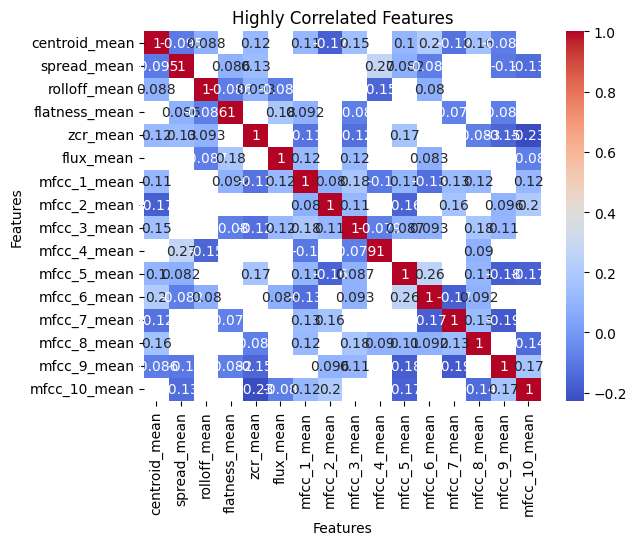

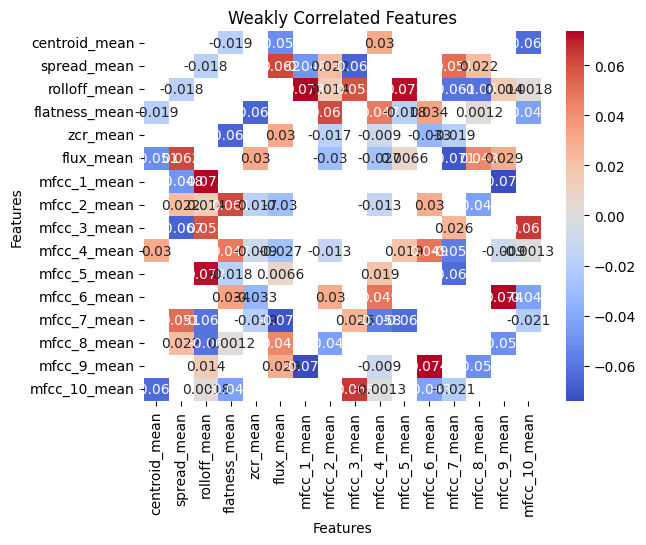

In [69]:

#Make one plot (with a title and axes properly labeled to show what is being plotted) of two highly correlated features


#define and compute meaningful high and low correlation thresholds by computing zscore normalization of the correlation values
# zscore_corr = zscore(correlation_matrix, axis=None)
thresholds = 0.075  # Example threshold for high correlation


# Highly correlated features
high_corr = correlation_matrix[np.abs(correlation_matrix) > thresholds]
sns.heatmap(high_corr, annot=True, cmap='coolwarm')
plt.title('Highly Correlated Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

# and another plot of two weakly correlated (or at least less correlated) features.
low_corr = correlation_matrix[np.abs(correlation_matrix) < thresholds]
sns.heatmap(low_corr, annot=True, cmap='coolwarm')
plt.title('Weakly Correlated Features')
plt.xlabel('Features')
plt.ylabel('Features')
plt.show()

In [72]:
#knn classifier
#initualize the model
knn = KNeighborsClassifier(n_neighbors=5)
#load the data
X_train = df.drop(columns=['filename', 'label']).to_numpy()
y_train = df['label'].to_numpy()

#split the data into training and testing sets#train the model
knn.fit(X_train, y_train)

#load test data
X_test = df_test.drop(columns=['filename', 'label']).to_numpy()
y_test = df_test['label'].to_numpy()

#make predictions
y_pred = knn.predict(X_test)
#evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy*100:.2f}%')
#save the model

Accuracy: 35.00%


In [ ]:
#import audio files
Flute_file = '/Users/jameswang/workspace/Audio Content Analysis/audios/FourInstrumentFiles_export/Fl-F4-mf.wav'
OB_File = '/Users/jameswang/workspace/Audio Content Analysis/audios/FourInstrumentFiles_export/Ob-F4-mf.wav'
Trumpet_file = '/Users/jameswang/workspace/Audio Content Analysis/audios/FourInstrumentFiles_export/TpC-F4-mf.wav'
Violin_file = '/Users/jameswang/workspace/Audio Content Analysis/audios/FourInstrumentFiles_export/Vn-F4-mf.wav'
Flute, sr = librosa.load(Flute_file, sr=None)
OB, sr = librosa.load(OB_File, sr=None)
Trumpet, sr = librosa.load(Trumpet_file, sr=None)
Violin, sr = librosa.load(Violin_file, sr=None)

In [ ]:
#calculate Spectral Centroid
Flute_centroid = librosa.feature.spectral_centroid(y=Flute, sr=sr)
OB_centroid = librosa.feature.spectral_centroid(y=OB, sr=sr)
Trumpet_centroid = librosa.feature.spectral_centroid(y=Trumpet, sr=sr)
Violin_centroid = librosa.feature.spectral_centroid(y=Violin, sr=sr)

In [ ]:
#calculate Spectral spread
Flute_spread = librosa.feature.spectral_bandwidth(y=Flute, sr=sr)
OB_spread = librosa.feature.spectral_bandwidth(y=OB, sr=sr)
Trumpet_spread = librosa.feature.spectral_bandwidth(y=Trumpet, sr=sr)
Violin_spread = librosa.feature.spectral_bandwidth(y=Violin, sr=sr)

In [ ]:
#calculate spectral flux
def spectral_flux(y, sr, n_fft=2048, hop_length=512):
    # Compute the Short-Time Fourier Transform (STFT)
    S = np.abs(librosa.stft(y, n_fft=n_fft, hop_length=hop_length))
    
    # Normalize the spectrogram
    S_norm = S / np.sum(S, axis=0, keepdims=True)
    
    # Compute the spectral flux
    flux = np.sqrt(np.sum(np.diff(S_norm, axis=1)**2, axis=0))
    
    return flux

Flute_flux = spectral_flux(Flute, sr)
OB_flux = spectral_flux(OB, sr)
Trumpet_flux = spectral_flux(Trumpet, sr)
Violin_flux = spectral_flux(Violin, sr)

In [ ]:
#calculate MFCCs
Flute_mfccs = librosa.feature.mfcc(y=Flute, sr=sr, n_mfcc=13)
OB_mfccs = librosa.feature.mfcc(y=OB, sr=sr, n_mfcc=13)
Trumpet_mfccs = librosa.feature.mfcc(y=Trumpet, sr=sr, n_mfcc=13)
Violin_mfccs = librosa.feature.mfcc(y=Violin, sr=sr, n_mfcc=13)

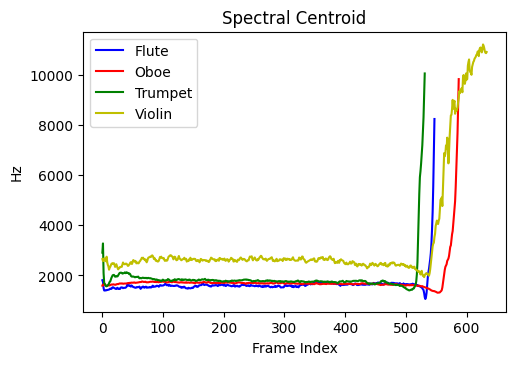

In [ ]:
#visualization centroid for all four instruments
labels = ['Flute', 'Oboe', 'Trumpet', 'Violin']
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars   
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(Flute_centroid[0], label='Flute', color='b')
plt.plot(OB_centroid[0], label='Oboe', color='r')
plt.plot(Trumpet_centroid[0], label='Trumpet', color='g')
plt.plot(Violin_centroid[0], label='Violin', color='y')
plt.title('Spectral Centroid')
plt.xlabel('Frame Index')
plt.ylabel('Hz')
plt.legend()
plt.show()

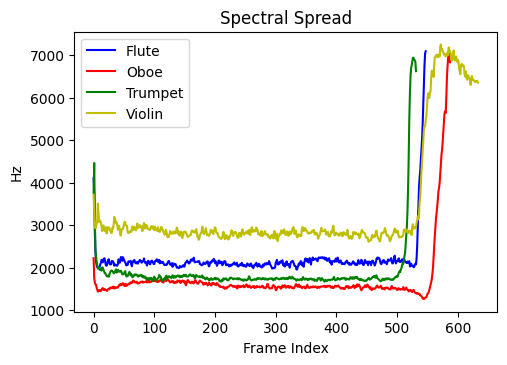

In [ ]:
#plot spectral spread for all four instruments
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(Flute_spread[0], label='Flute', color='b')
plt.plot(OB_spread[0], label='Oboe', color='r')
plt.plot(Trumpet_spread[0], label='Trumpet', color='g')
plt.plot(Violin_spread[0], label='Violin', color='y')
plt.title('Spectral Spread')
plt.xlabel('Frame Index')
plt.ylabel('Hz')
plt.legend()
plt.show()

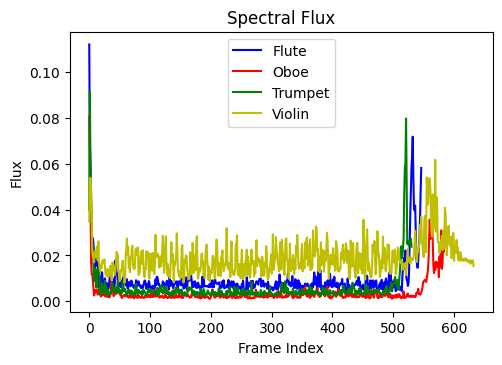

In [ ]:
#plot spectral flux for all four instruments
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(Flute_flux, label='Flute', color='b')
plt.plot(OB_flux, label='Oboe', color='r')
plt.plot(Trumpet_flux, label='Trumpet', color='g')
plt.plot(Violin_flux, label='Violin', color='y')
plt.title('Spectral Flux')
plt.xlabel('Frame Index')
plt.ylabel('Flux')
plt.legend()
plt.show()

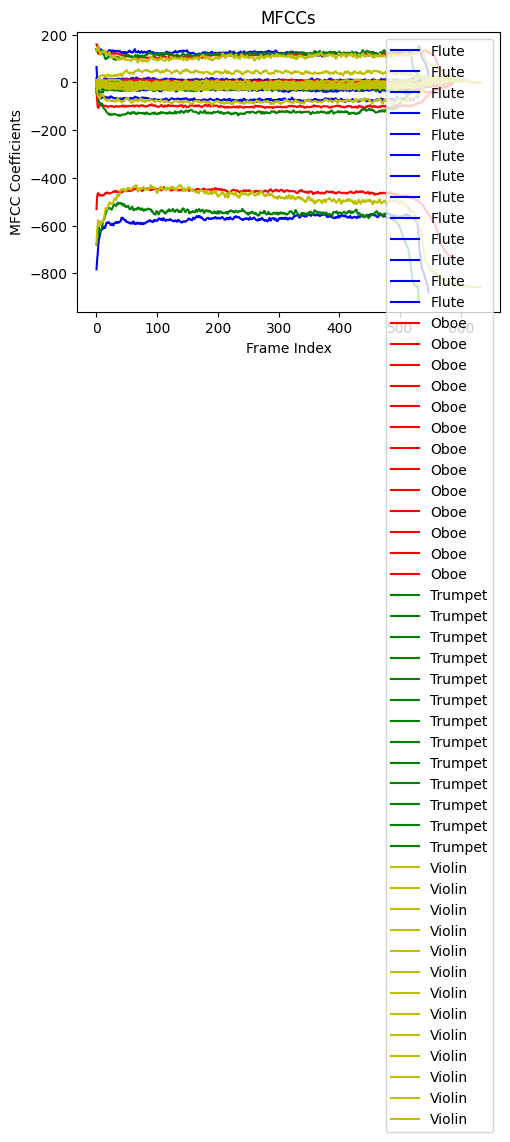

In [ ]:
#plot mfccs for all four instruments
plt.figure(figsize=(12, 8))
plt.subplot(2, 2, 1)
plt.plot(Flute_mfccs.T, label='Flute', color='b')               
plt.plot(OB_mfccs.T, label='Oboe', color='r')
plt.plot(Trumpet_mfccs.T, label='Trumpet', color='g')
plt.plot(Violin_mfccs.T, label='Violin', color='y')
plt.title('MFCCs')
plt.xlabel('Frame Index')
plt.ylabel('MFCC Coefficients')
plt.legend()
plt.show()